# Customer Satisfaction Classification using Facial Expressions

This notebook implements a customer satisfaction classification system using facial expressions from the FER2013 dataset. The system classifies customer expressions into three categories:
- Satisfied
- Neutral
- Unsatisfied

We'll use the FER2013 dataset which contains facial emotion images and remap the 7 emotion classes to our 3 satisfaction classes.

## 1. Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import cv2
from tqdm import tqdm

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Explore the FER2013 Dataset

The FER2013 dataset is typically in CSV format with the following structure:
- emotion: label (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
- pixels: string of space-separated pixel values (48x48 grayscale image)
- usage: Training, PublicTest, or PrivateTest

In [2]:
# Load the dataset
# Note: You need to download the FER2013 dataset from Kaggle and place it in your working directory
# https://www.kaggle.com/datasets/msambare/fer2013

try:
   drive.mount('/content/drive', force_remount=True) # Added force_remount for re-running
   drive_path = '/content/drive/MyDrive/fer2013.csv'
   data = pd.read_csv(drive_path)
except FileNotFoundError:
    print("Dataset not found. Please download the FER2013 dataset from Kaggle and place it in your working directory.")
    print("URL: https://www.kaggle.com/datasets/msambare/fer2013")

Mounted at /content/drive


Dataset shape: (35887, 3)

Dataset columns:
Index(['emotion', 'pixels', 'Usage'], dtype='object')

Sample data:


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training



Missing values:
emotion    0
pixels     0
Usage      0
dtype: int64

Emotion distribution:
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: count, dtype: int64


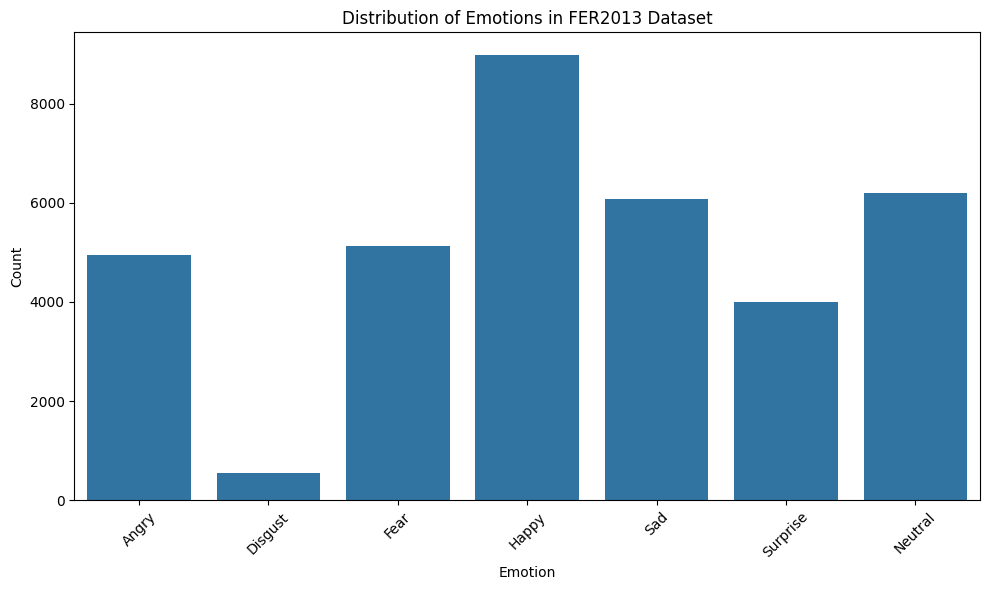

In [3]:
# Display basic information about the dataset
try:
    print(f"Dataset shape: {data.shape}")
    print("\nDataset columns:")
    print(data.columns)
    print("\nSample data:")
    display(data.head())

    # Check for missing values
    print("\nMissing values:")
    print(data.isnull().sum())

    # Distribution of emotions
    print("\nEmotion distribution:")
    emotion_counts = data['emotion'].value_counts().sort_index()
    print(emotion_counts)

    # Map emotion labels to their names
    emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                      4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    # Plot emotion distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index.map(lambda x: emotion_labels[x]), y=emotion_counts.values)
    plt.title('Distribution of Emotions in FER2013 Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except NameError:
    print("Dataset not loaded yet.")

## 3. Data Preprocessing

### 3.1 Convert Pixel Strings to Images

In [4]:
def preprocess_data(dataframe):
    """Convert pixel strings to image arrays and normalize."""
    if 'pixels' not in dataframe.columns:
        return None, None

    # Extract features (pixel values) and labels (emotions)
    X = []
    y = dataframe['emotion'].values

    # Convert each pixel string to a 48x48 image
    for pixel_sequence in tqdm(dataframe['pixels'].values):
        pixel_array = np.array(pixel_sequence.split(' '), dtype='float32')
        image = pixel_array.reshape(48, 48)
        X.append(image)

    # Convert list to numpy array
    X = np.array(X)

    # Normalize pixel values to [0, 1]
    X = X / 255.0

    # Reshape for CNN input (add channel dimension)
    X = X.reshape(X.shape[0], 48, 48, 1)

    return X, y

100%|██████████| 35887/35887 [00:12<00:00, 2765.02it/s]


Processed 35887 images
Image shape: (48, 48, 1)
Label shape: (35887,)


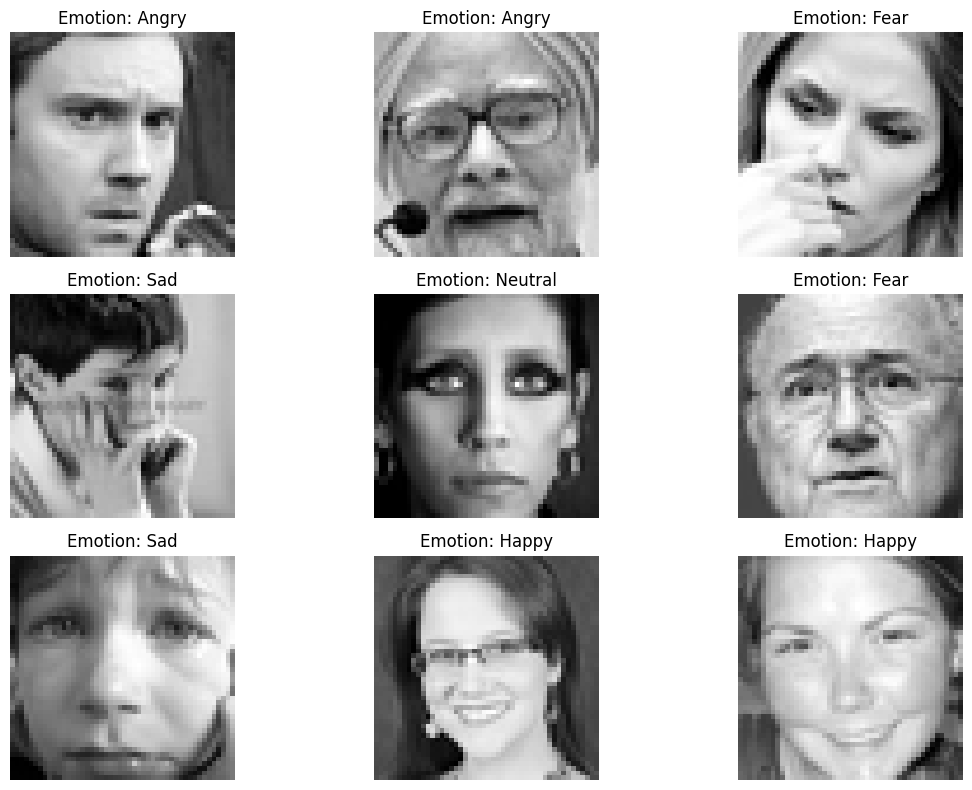

In [5]:
try:
    # Process the data
    X, y = preprocess_data(data)

    if X is not None:
        print(f"Processed {X.shape[0]} images")
        print(f"Image shape: {X.shape[1:]}")
        print(f"Label shape: {y.shape}")

        # Display some sample images
        plt.figure(figsize=(12, 8))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(X[i].reshape(48, 48), cmap='gray')
            plt.title(f"Emotion: {emotion_labels[y[i]]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
except NameError:
    print("Dataset not loaded yet.")

### 3.2 Map 7 Emotions to 3 Customer Satisfaction Classes

We'll map the 7 emotion classes to 3 customer satisfaction classes:
- Satisfied: Happy (3), Surprise (5)
- Neutral: Neutral (6)
- Unsatisfied: Angry (0), Disgust (1), Fear (2), Sad (4)

In [6]:
def map_emotions_to_satisfaction(emotions):
    """Map the 7 emotion classes to 3 satisfaction classes."""
    satisfaction_mapping = {
        0: 2,  # Angry -> Unsatisfied
        1: 2,  # Disgust -> Unsatisfied
        2: 2,  # Fear -> Unsatisfied
        3: 0,  # Happy -> Satisfied
        4: 2,  # Sad -> Unsatisfied
        5: 0,  # Surprise -> Satisfied
        6: 1   # Neutral -> Neutral
    }

    satisfaction = np.array([satisfaction_mapping[emotion] for emotion in emotions])
    return satisfaction

Satisfaction class distribution:
Satisfied: 12991 (36.20%)
Neutral: 6198 (17.27%)
Unsatisfied: 16698 (46.53%)


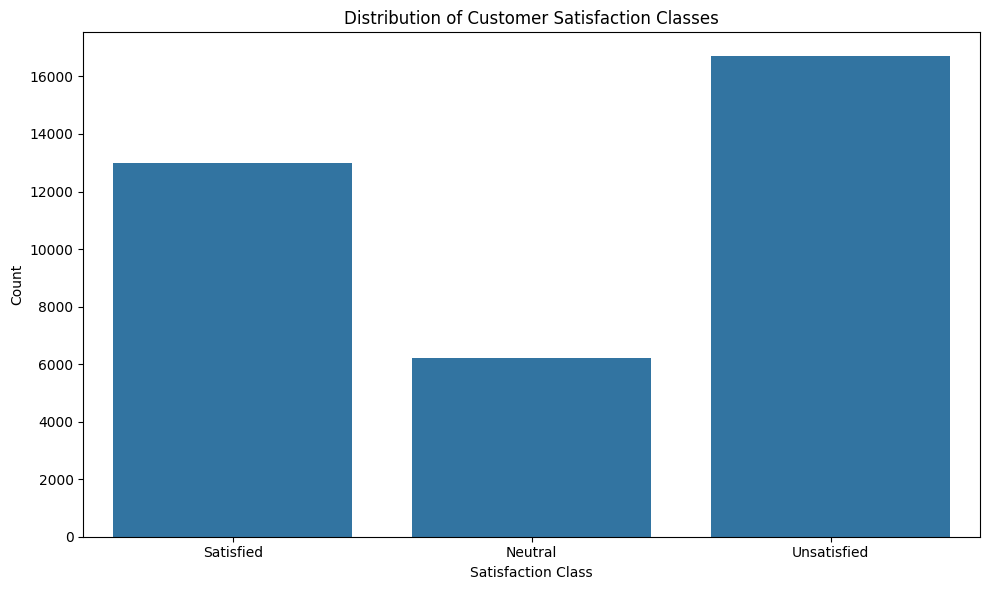

In [7]:
try:
    # Map emotions to satisfaction classes
    satisfaction_labels = {0: 'Satisfied', 1: 'Neutral', 2: 'Unsatisfied'}
    satisfaction_y = map_emotions_to_satisfaction(y)

    # Display the distribution of satisfaction classes
    satisfaction_counts = pd.Series(satisfaction_y).value_counts().sort_index()
    print("Satisfaction class distribution:")
    for idx, count in satisfaction_counts.items():
        print(f"{satisfaction_labels[idx]}: {count} ({count/len(satisfaction_y)*100:.2f}%)")

    # Plot satisfaction distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=satisfaction_counts.index.map(lambda x: satisfaction_labels[x]), y=satisfaction_counts.values)
    plt.title('Distribution of Customer Satisfaction Classes')
    plt.xlabel('Satisfaction Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
except NameError:
    print("Dataset not processed yet.")

### 3.3 Split the Data into Training, Validation, and Test Sets

In [8]:
try:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, satisfaction_y, test_size=0.2, random_state=42, stratify=satisfaction_y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    print(f"Training set: {X_train.shape[0]} images")
    print(f"Validation set: {X_val.shape[0]} images")
    print(f"Test set: {X_test.shape[0]} images")

    # Convert labels to one-hot encoding for multi-class classification
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=3)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)
except NameError:
    print("Dataset not processed yet.")

Training set: 22967 images
Validation set: 5742 images
Test set: 7178 images


### 3.4 Data Augmentation for Training

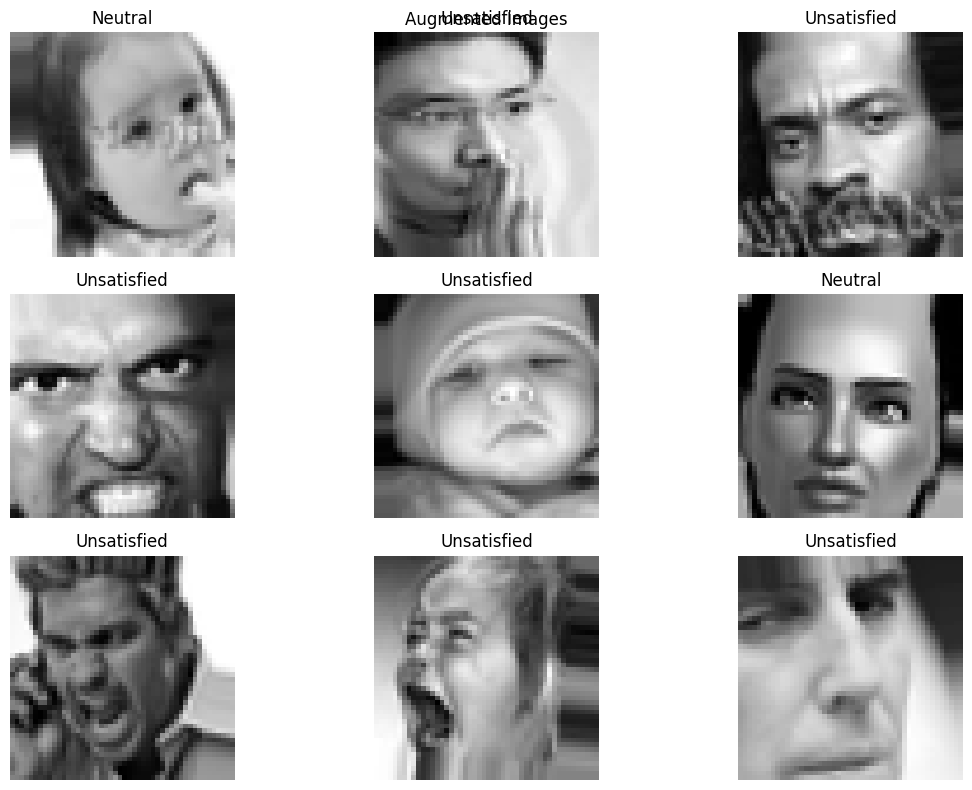

In [9]:
# Create data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

try:
    # Visualize some augmented images
    plt.figure(figsize=(12, 8))
    for i, (image, label) in enumerate(zip(X_train[:9], y_train[:9])):
        ax = plt.subplot(3, 3, i + 1)
        image = image.reshape((1,) + image.shape)
        augmented_image = next(datagen.flow(image, batch_size=1))[0]
        plt.imshow(augmented_image.reshape(48, 48), cmap='gray')
        plt.title(f"{satisfaction_labels[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Augmented Images')
    plt.show()
except NameError:
    print("Dataset not processed yet.")

## 4. Build the CNN Model for Customer Satisfaction Classification

In [10]:
def build_model():
    """Build a CNN model for customer satisfaction classification."""
    model = Sequential([
        # First convolutional block
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
        BatchNormalization(),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes: Satisfied, Neutral, Unsatisfied
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
try:
    # Build the model
    model = build_model()

    # Display model summary
    model.summary()

    # Plot model architecture
    tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    display(plt.imread('model_architecture.png'))
except NameError:
    print("Required libraries or data not loaded yet.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,783,203 (10.62 MB)

 Trainable params: 2,780,771 (10.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

array([[[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ]],

       [[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ]],

       [[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.      

## 5. Train the Model

In [12]:
try:
    # Set up callbacks for training
    checkpoint = ModelCheckpoint(
        'satisfaction_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Train the model with data augmentation
    batch_size = 64
    epochs = 50

    # Fit the model
    history = model.fit(
        datagen.flow(X_train, y_train_onehot, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val_onehot),
        callbacks=callbacks
    )
except NameError:
    print("Model or data not defined yet.")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3940 - loss: 1.4935
Epoch 1: val_accuracy improved from -inf to 0.48763, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.3941 - loss: 1.4924 - val_accuracy: 0.4876 - val_loss: 1.0317 - learning_rate: 0.0010
Epoch 2/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4844 - loss: 1.0728

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.48763 to 0.48798, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4844 - loss: 1.0728 - val_accuracy: 0.4880 - val_loss: 1.0312 - learning_rate: 0.0010
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4803 - loss: 1.0265
Epoch 3: val_accuracy improved from 0.48798 to 0.55730, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.4803 - loss: 1.0264 - val_accuracy: 0.5573 - val_loss: 0.9291 - learning_rate: 0.0010
Epoch 4/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5938 - loss: 0.9267
Epoch 4: val_accuracy did not improve from 0.55730
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.9267 - val_accuracy: 0.5535 - val_loss: 0.9316 - learning_rate: 0.0010
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5290 - loss: 0.9551
Epoch 5: val_accuracy improved from 0.55730 to 0.64089, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5291 - loss: 0.9551 - val_accuracy: 0.6409 - val_loss: 0.8027 - learning_rate: 0.0010
Epoch 6/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5312 - loss: 0.8921
Epoch 6: val_accuracy did not improve from 0.64089
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 0.8921 - val_accuracy: 0.6383 - val_loss: 0.8096 - learning_rate: 0.0010
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5953 - loss: 0.8703
Epoch 7: val_accuracy improved from 0.64089 to 0.64211, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5953 - loss: 0.8703 - val_accuracy: 0.6421 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 8/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6875 - loss: 0.7430
Epoch 8: val_accuracy did not improve from 0.64211
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.7430 - val_accuracy: 0.6371 - val_loss: 0.7876 - learning_rate: 0.0010
Epoch 9/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6474 - loss: 0.7913
Epoch 9: val_accuracy improved from 0.64211 to 0.68652, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6474 - loss: 0.7913 - val_accuracy: 0.6865 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 10/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6094 - loss: 0.8083
Epoch 10: val_accuracy did not improve from 0.68652
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6094 - loss: 0.8083 - val_accuracy: 0.6816 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 11/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6745 - loss: 0.7484
Epoch 11: val_accuracy improved from 0.68652 to 0.71073, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6745 - loss: 0.7483 - val_accuracy: 0.7107 - val_loss: 0.6741 - learning_rate: 0.0010
Epoch 12/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7188 - loss: 0.6556
Epoch 12: val_accuracy did not improve from 0.71073
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.6556 - val_accuracy: 0.7071 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 13/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6864 - loss: 0.7163
Epoch 13: val_accuracy improved from 0.71073 to 0.71752, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6864 - loss: 0.7163 - val_accuracy: 0.7175 - val_loss: 0.6613 - learning_rate: 0.0010
Epoch 14/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7656 - loss: 0.6210
Epoch 14: val_accuracy did not improve from 0.71752
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7656 - loss: 0.6210 - val_accuracy: 0.7119 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 15/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7019 - loss: 0.6879
Epoch 15: val_accuracy improved from 0.71752 to 0.72867, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7019 - loss: 0.6880 - val_accuracy: 0.7287 - val_loss: 0.6536 - learning_rate: 0.0010
Epoch 16/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6875 - loss: 0.7587
Epoch 16: val_accuracy did not improve from 0.72867
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.7587 - val_accuracy: 0.7187 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 17/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7097 - loss: 0.6708
Epoch 17: val_accuracy improved from 0.72867 to 0.73267, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7097 - loss: 0.6708 - val_accuracy: 0.7327 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 18/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7031 - loss: 0.7617
Epoch 18: val_accuracy did not improve from 0.73267
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 0.7617 - val_accuracy: 0.7288 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 19/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7119 - loss: 0.6678
Epoch 19: val_accuracy improved from 0.73267 to 0.73946, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.7119 - loss: 0.6678 - val_accuracy: 0.7395 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 20/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6562 - loss: 0.7681
Epoch 20: val_accuracy did not improve from 0.73946
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.7681 - val_accuracy: 0.7381 - val_loss: 0.6211 - learning_rate: 0.0010
Epoch 21/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7205 - loss: 0.6519
Epoch 21: val_accuracy did not improve from 0.73946
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7205 - loss: 0.6519 - val_accuracy: 0.7388 - val_loss: 0.6083 - learning_rate: 0.0010
Epoch 22/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8125 - loss: 0.5644
Epoch 22: val_accuracy improved from 0.73946 to 0.74364, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.5644 - val_accuracy: 0.7436 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 23/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7250 - loss: 0.6402
Epoch 23: val_accuracy improved from 0.74364 to 0.74678, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7250 - loss: 0.6402 - val_accuracy: 0.7468 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 24/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7031 - loss: 0.6842
Epoch 24: val_accuracy did not improve from 0.74678
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 0.6842 - val_accuracy: 0.7456 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 25/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7311 - loss: 0.6299
Epoch 25: val_accuracy did not improve from 0.74678
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7311 - loss: 0.6299 - val_accuracy: 0.6829 - val_loss: 0.7124 - learning_rate: 0.0010
Epoch 26/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7812 - loss: 0.5802
Epoch 26: val_accuracy did not improve from 0.74678
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.5802 - val_accuracy: 0.6848 - val_loss: 0.7109 - learning_rate: 0.0010
Epoch 27/50


358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7363 - loss: 0.6119 - val_accuracy: 0.7691 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 28/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8281 - loss: 0.5950
Epoch 28: val_accuracy did not improve from 0.76907
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.5950 - val_accuracy: 0.7675 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 29/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7475 - loss: 0.5955
Epoch 29: val_accuracy did not improve from 0.76907
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7475 - loss: 0.5956 - val_accuracy: 0.7616 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 30/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7656 - loss: 0.5618
Epoch 30: val_accuracy did not improve from 0.76907
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.5618 - val_accuracy: 0.7647 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 31/50


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7550 - loss: 0.5789 - val_accuracy: 0.7727 - val_loss: 0.5308 - learning_rate: 2.0000e-04
Epoch 34/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7500 - loss: 0.6110
Epoch 34: val_accuracy did not improve from 0.77273
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.6110 - val_accuracy: 0.7727 - val_loss: 0.5299 - learning_rate: 2.0000e-04
Epoch 35/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7720 - loss: 0.5481
Epoch 35: val_accuracy improved from 0.77273 to 0.77656, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7720 - loss: 0.5481 - val_accuracy: 0.7766 - val_loss: 0.5270 - learning_rate: 2.0000e-04
Epoch 36/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7188 - loss: 0.6211
Epoch 36: val_accuracy did not improve from 0.77656
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.6211 - val_accuracy: 0.7764 - val_loss: 0.5273 - learning_rate: 2.0000e-04
Epoch 37/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7773 - loss: 0.5315
Epoch 37: val_accuracy improved from 0.77656 to 0.77865, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7773 - loss: 0.5315 - val_accuracy: 0.7786 - val_loss: 0.5274 - learning_rate: 2.0000e-04
Epoch 38/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7812 - loss: 0.4914
Epoch 38: val_accuracy did not improve from 0.77865
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.4914 - val_accuracy: 0.7780 - val_loss: 0.5274 - learning_rate: 2.0000e-04
Epoch 39/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7782 - loss: 0.5287
Epoch 39: val_accuracy did not improve from 0.77865
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7782 - loss: 0.5288 - val_accuracy: 0.7753 - val_loss: 0.5351 - learning_rate: 2.0000e-04
Epoch 40/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8125 - loss: 0.4871
Epoch 40: val_accuracy did not improve from 0.77865

Epoch 40: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - 

358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7787 - loss: 0.5307 - val_accuracy: 0.7839 - val_loss: 0.5190 - learning_rate: 4.0000e-05
Epoch 42/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7500 - loss: 0.6233
Epoch 42: val_accuracy improved from 0.78387 to 0.78405, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.6233 - val_accuracy: 0.7840 - val_loss: 0.5191 - learning_rate: 4.0000e-05
Epoch 43/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7734 - loss: 0.5367
Epoch 43: val_accuracy improved from 0.78405 to 0.78753, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7735 - loss: 0.5366 - val_accuracy: 0.7875 - val_loss: 0.5152 - learning_rate: 4.0000e-05
Epoch 44/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7344 - loss: 0.6041
Epoch 44: val_accuracy improved from 0.78753 to 0.78788, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7344 - loss: 0.6041 - val_accuracy: 0.7879 - val_loss: 0.5153 - learning_rate: 4.0000e-05
Epoch 45/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7829 - loss: 0.5168
Epoch 45: val_accuracy did not improve from 0.78788
358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.7829 - loss: 0.5169 - val_accuracy: 0.7870 - val_loss: 0.5145 - learning_rate: 4.0000e-05
Epoch 46/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7656 - loss: 0.5006
Epoch 46: val_accuracy did not improve from 0.78788
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.5006 - val_accuracy: 0.7870 - val_loss: 0.5146 - learning_rate: 4.0000e-05
Epoch 47/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7826 - loss: 0.5271
Epoch 47: val_accuracy improved from 0.78788 to 0.79084, saving model to satisfaction_model_best.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.7826 - loss: 0.5270 - val_accuracy: 0.7908 - val_loss: 0.5118 - learning_rate: 4.0000e-05
Epoch 48/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7656 - loss: 0.6139
Epoch 48: val_accuracy did not improve from 0.79084
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.6139 - val_accuracy: 0.7905 - val_loss: 0.5118 - learning_rate: 4.0000e-05
Epoch 49/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7839 - loss: 0.5175
Epoch 49: val_accuracy did not improve from 0.79084
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7839 - loss: 0.5175 - val_accuracy: 0.7868 - val_loss: 0.5140 - learning_rate: 4.0000e-05
Epoch 50/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8281 - loss: 0.5403
Epoch 50: val_accuracy did not improve from 0.79084
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.5403 - val_accuracy: 0.7865 - val_loss: 0.5140 - learning_rate: 4.0000e

## 6. Evaluate the Model

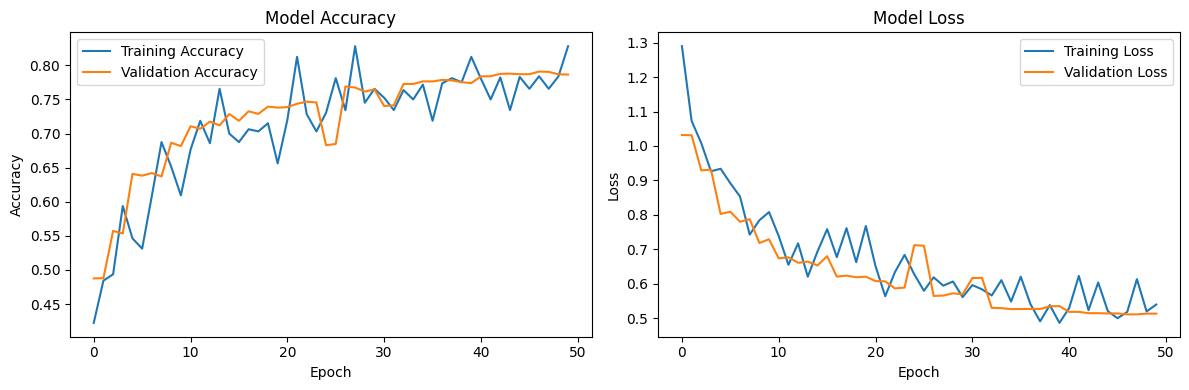

In [13]:
try:
    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
except NameError:
    print("Training history not available yet.")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7832 - loss: 0.5201
Test Loss: 0.5147
Test Accuracy: 0.7856
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


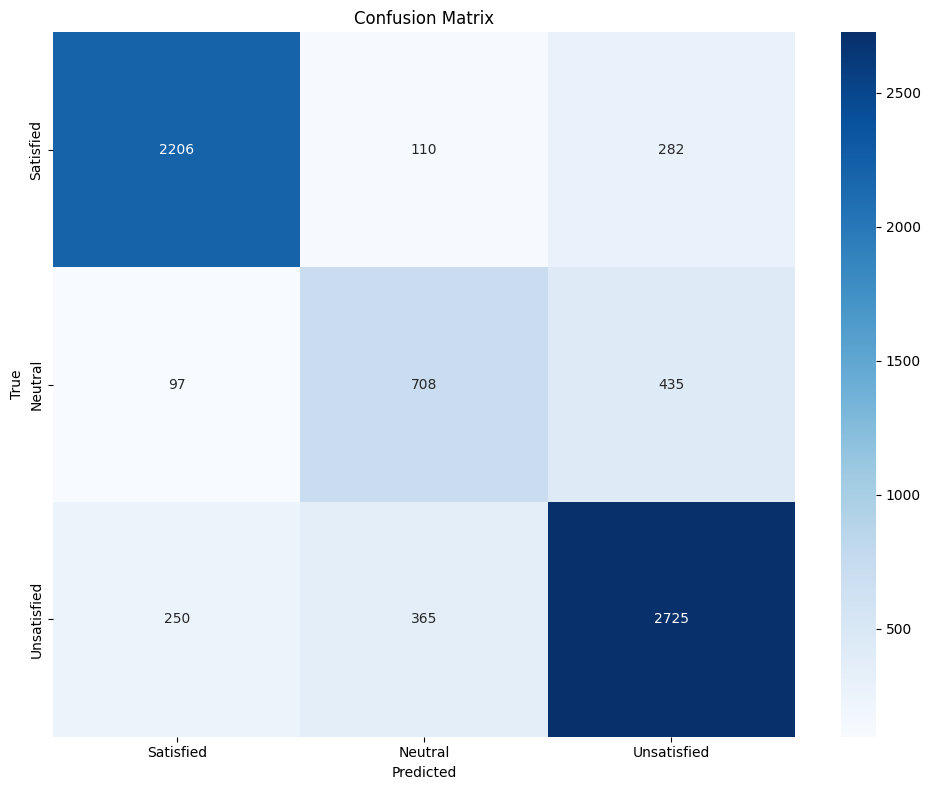


Classification Report:
              precision    recall  f1-score   support

   Satisfied       0.86      0.85      0.86      2598
     Neutral       0.60      0.57      0.58      1240
 Unsatisfied       0.79      0.82      0.80      3340

    accuracy                           0.79      7178
   macro avg       0.75      0.75      0.75      7178
weighted avg       0.78      0.79      0.78      7178



In [14]:
try:
    # Load the best model
    best_model = tf.keras.models.load_model('satisfaction_model_best.h5')

    # Evaluate on test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Get predictions
    y_pred_probs = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[satisfaction_labels[i] for i in range(3)],
                yticklabels=[satisfaction_labels[i] for i in range(3)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=[satisfaction_labels[i] for i in range(3)]))
except (NameError, FileNotFoundError):
    print("Model not trained yet or best model file not found.")

## 7. Visualize Predictions

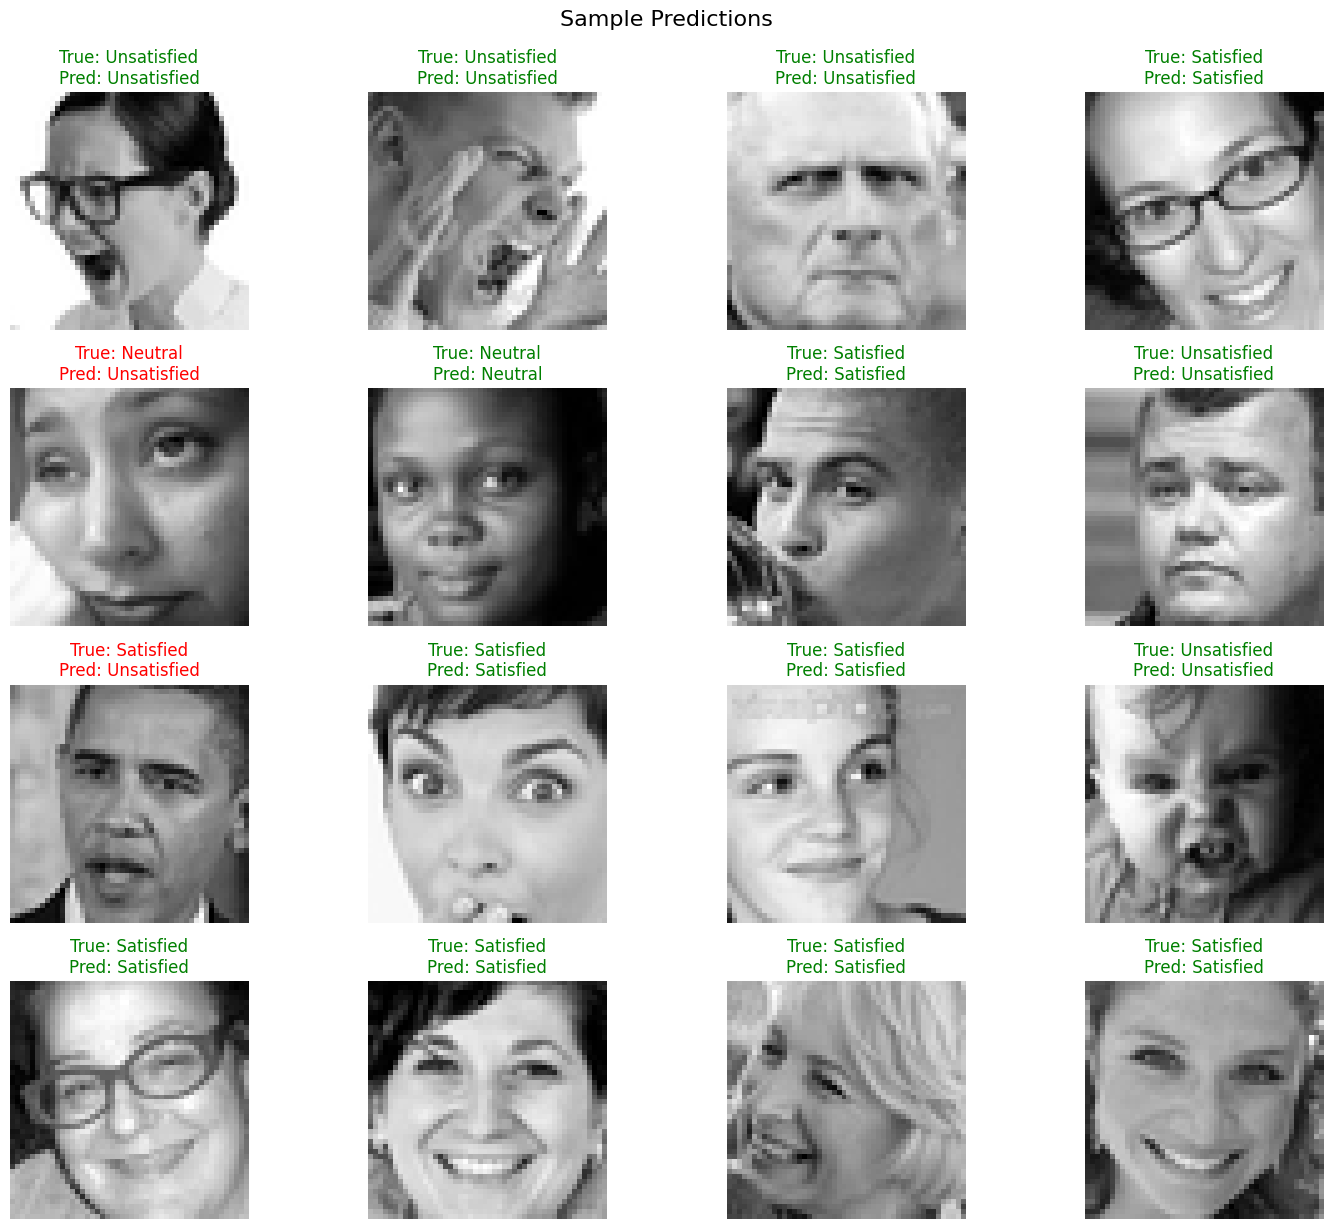

In [15]:
try:
    # Visualize some predictions
    num_samples = 16
    indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

    # Get predictions
    sample_images = X_test[indices]
    sample_true = y_test[indices]
    sample_preds = y_pred[indices]

    # Plot
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(range(num_samples)):
        plt.subplot(4, 4, i+1)
        plt.imshow(sample_images[idx].reshape(48, 48), cmap='gray')

        true_label = satisfaction_labels[sample_true[idx]]
        pred_label = satisfaction_labels[sample_preds[idx]]

        # Color the title based on correct/incorrect prediction
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Sample Predictions', fontsize=16, y=1.02)
    plt.show()
except NameError:
    print("Predictions not available yet.")

## 8. Real-world Application: Customer Satisfaction Prediction

In [16]:
# Example usage (uncomment and use when you have a test image)

try:
    best_model = tf.keras.models.load_model('/content/satisfaction_model_best.h5')
    # Path to your test image
    test_image_path = '/content/sadd.png'

    # Make prediction
    result = predict_satisfaction(test_image_path, best_model)

    if isinstance(result, tuple):
        pred_label, confidence, pred_probs = result

        # Display the image and prediction
        img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted: {pred_label} (Confidence: {confidence:.2f}%)")
        plt.axis('off')
        plt.show()

        # Display probability distribution
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(satisfaction_labels.values()), y=pred_probs)
        plt.title('Prediction Probabilities')
        plt.xlabel('Satisfaction Class')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    else:
        print(result)  # Print error message
except NameError:
    print("Model not loaded yet.")


Model not loaded yet.


## 9. Conclusion and Next Steps

In this notebook, we've built a customer satisfaction classification system using facial expressions from the FER2013 dataset. We've mapped the 7 emotion classes to 3 satisfaction classes (Satisfied, Neutral, Unsatisfied) and trained a CNN model to predict these classes.

### Potential Next Steps:

1. **Improve Model Performance**:
   - Try different model architectures
   - Experiment with transfer learning using pre-trained models
   - Apply more advanced data augmentation techniques

2. **Real-time Implementation**:
   - Integrate with webcam for real-time customer satisfaction monitoring
   - Develop a dashboard to track satisfaction metrics over time

3. **Deployment**:
   - Convert the model to TensorFlow Lite for mobile applications
   - Deploy as a web service using Flask or FastAPI
   - Create a simple UI for business users

4. **Additional Features**:
   - Add age and gender detection
   - Track satisfaction trends over time
   - Combine with other customer feedback data for a more comprehensive analysis